# Imports

In [264]:
import numpy as np
import h5py
from scipy import signal
import matplotlib.pyplot as plt

# Cargamos las señales

In [265]:
H1 = h5py.File('H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')
L1 = h5py.File('L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')

In [266]:
print(list(H1.keys()))
print(list(L1.keys()))

['meta', 'quality', 'strain']
['meta', 'quality', 'strain']


In [267]:
for element in H1['meta']:
  print(element)
for element in H1['quality']:
  print(element)
for element in H1['strain']:
  print(element)

Description
DescriptionURL
Detector
Duration
GPSstart
Observatory
Type
UTCstart
detail
injections
simple
Strain


In [268]:
metaH1 = H1[u'meta']
qualityH1 = H1[u'quality']
strainH1 = H1[u'strain']
metaL1 = L1[u'meta']
qualityL1 = L1[u'quality']
strainL1 = L1[u'strain']

In [269]:
dataH1 = np.array(strainH1['Strain'])
dataL1 = np.array(strainL1['Strain'])

In [270]:
print('strain_H1: len, min, mean, max = ', len(dataH1), dataH1.min(),dataH1.mean(),dataH1.max())
print('strain_L1: len, min, mean, max = ', len(dataL1), dataL1.min(),dataL1.mean(),dataL1.max())

strain_H1: len, min, mean, max =  131072 -7.04466594316914e-19 -3.7594485871462737e-23 7.706262192395323e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664246853e-18 -1.0522364772927026e-18 -4.600351113064713e-20


In [271]:
print(dataH1)
print(dataL1)

[9.06730891e-21 2.01178871e-20 3.71290472e-20 ... 5.32101440e-20
 4.74831535e-20 7.76456828e-20]
[-1.00432555e-18 -9.58114996e-19 -9.03059379e-19 ... -1.10862808e-18
 -1.13349772e-18 -1.12487097e-18]


# Ploteamos las señales

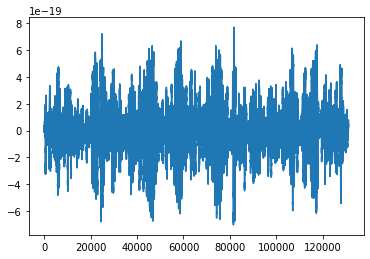

In [272]:
plt.plot(dataH1)
plt.show()

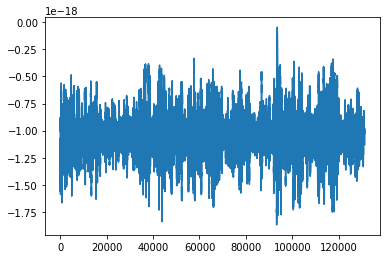

In [273]:
plt.plot(dataL1)
plt.show()

## Estimacion del espectro de potencia del ruido de H1 y L1

**Periodograma**

In [274]:
N_event = 65536
fftL1 = np.fft.rfft(dataL1[0:N_event])
fftH1 = np.fft.rfft(dataH1[0:N_event])

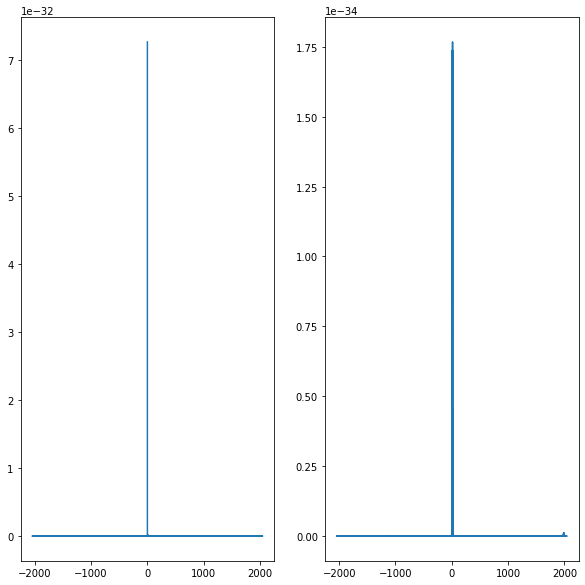

In [275]:
freqL1 = np.fft.fftfreq(len(fftL1),d=1/4096)
#freqL1 = np.fft.fftshift(freqL1)
freqH1 = np.fft.fftfreq(len(fftH1),d=1/4096)
#freqH1 = np.fft.fftshift(freqH1)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.plot(freqL1, abs(fftL1)**2/N_event)
#plt.xlim(left=-20,right=20)
plt.subplot(122)
plt.plot(freqH1, abs(fftH1)**2/N_event)
#plt.xlim(left=-20,right=20)
plt.show()

In [276]:
def plotStrainASD(freqs1, freqs2, Pxx1, Pxx2, fmin, fmax, filename='ASD.png', show=True, yMin=1e-24, yMax=1e-19):
    plt.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
    plt.loglog(freqs1, np.sqrt(Pxx1),'r',label='H1 strain')
    plt.loglog(freqs2, np.sqrt(Pxx2),'g',label='L1 strain')
    plt.axis([fmin, fmax, yMin, yMax])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Amplitude Spectral Density')
    plt.savefig(filename)
    if show:
        plt.plot()

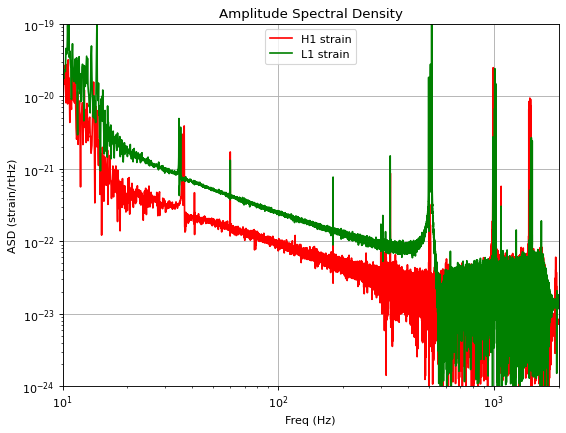

In [277]:
fs = 4096
norm = 2/fs
freqs1 = np.fft.fftfreq(len(dataL1[0:N_event]),d=1/4096)
freqs2 = np.fft.fftfreq(len(dataH1[0:N_event]),d=1/4096)
freqs1 = freqs1[:len(freqs1)//2]
freqs2 = freqs2[:len(freqs2)//2]
PxxH1_FFT = norm*abs(fftH1)**2/N_event
PxxL1_FFT = norm*abs(fftL1)**2/N_event
fmin = 10
fmax = 2000
plotStrainASD(freqs1,freqs2, PxxH1_FFT[:-1], PxxL1_FFT[:-1], fmin, fmax, filename='ASD-Periodogram.png')

**Metodo Welch Bartlett**

In [278]:
def segmentation(data,D,L,K):
  return [data[x:x+L] for x in range(0,K*(L-D),L-D)]

In [279]:
def windowSegments(segments,window):
  windowed = list()
  window = np.array(window)
  segments = np.array(segments)
  for segment in segments:
    # Apply Window to segment
    windowed.append(segment*window)
  return windowed

In [280]:
def dftSegments(segments,padding=None):
  if padding == None:
    zero_padding = 0
  else:
    zero_padding = padding
  dfts = list()
  for segment in segments:
    dft = np.fft.fft(segment,n=len(segment)+zero_padding)
    dfts.append(dft)
  return dfts

In [281]:
def spectrumSegments(dfts):
  spectrums = list()
  for segment in dfts:
    auxSpec = abs(segment)**2
    spectrums.append(auxSpec[:int(len(segment)/2)+1])
  return spectrums

In [282]:
def cumSumSpectrums(spectrums,L,fs):
    if len(spectrums) == 1:
        return spectrums[0]*(2/fs)
    else:
        spectrum = np.zeros(len(spectrums[0]))
        norm = 2/(len(spectrums)*L*fs)
        for i in range(len(spectrums[0])):
            auxValue = 0
            for segment in spectrums:
                auxValue  = auxValue + segment[i]
            spectrum[i] = norm*auxValue
        return spectrum

In [283]:
# D: Overlap
# L: Longitud de segmentos
# K: Numero de segmentos
def welchBartlett(data,fs,D,L,k,window,padding=None):
  segmentsWB = segmentation(data,D,L,k)
  windowedWB = windowSegments(segmentsWB, window)
  dftsWB = dftSegments(windowedWB,padding)
  spectrumsWB = spectrumSegments(dftsWB)
  spectrumWB = cumSumSpectrums(spectrumsWB,L,fs)
  return spectrumWB

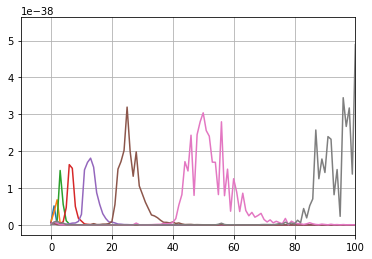

In [284]:
for i in range(8):
  nperseg = 2**(9+i)
  wbSpectrumL1 =  welchBartlett(dataL1, fs=4096, D=0, L=nperseg, k=int(len(dataL1)/nperseg), window = signal.get_window('boxcar', nperseg))
  wbSpectrumH1 =  welchBartlett(dataH1, fs=4096, D=0, L=nperseg, k=int(len(dataH1)/nperseg), window = signal.get_window('boxcar', nperseg))
  plt.plot(wbSpectrumH1)
plt.grid('on')
plt.xlim(left=-10,right=100)
plt.show()

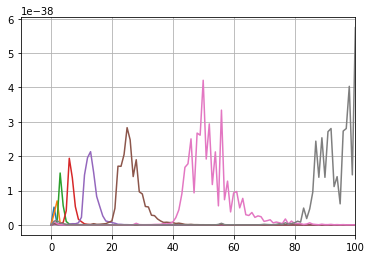

In [285]:
for i in range(8):
  nperseg = 2**(9+i)
  f, welch = signal.welch(dataH1,fs=4096,window = 'boxcar',nperseg=nperseg)
  plt.plot(welch)
plt.grid('on')
plt.xlim(left=-10,right=100)
plt.show()

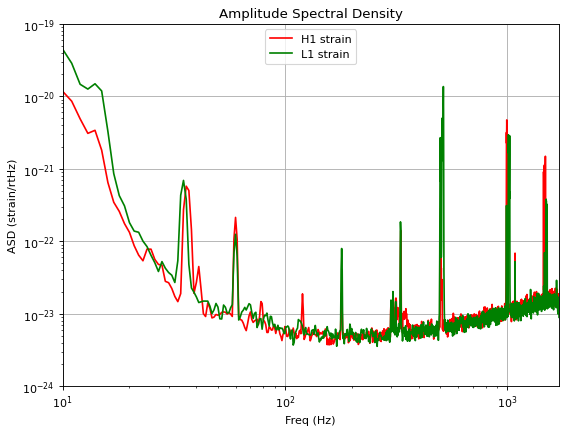

In [286]:
nperseg = 2**12
fmin = 10
fmax = 1700
freqs1 = np.fft.fftfreq(nperseg,d=1/4096)
freqs2 = np.fft.fftfreq(nperseg,d=1/4096)
freqs1 = freqs1[:len(freqs1)//2+1]
freqs2 = freqs2[:len(freqs2)//2+1]
PxxH1_WB =  welchBartlett(dataH1[0:65536], fs=4096, D=0, L=nperseg, k=int(65536/nperseg), window = signal.get_window('hann', nperseg))
PxxL1_WB =  welchBartlett(dataL1[0:65536], fs=4096, D=0, L=nperseg, k=int(65536/nperseg), window = signal.get_window('hann', nperseg))
plotStrainASD(freqs1, freqs2, PxxH1_WB, PxxL1_WB, fmin, fmax, filename='ASD-Welch-Bartlett-Method.png')

**Estimación multitaper**

In [287]:
def multitaperDPSS(data,n,fs):
    windows = signal.windows.dpss(M=len(data), NW=10, Kmax=n, sym=False, norm='approximate')
    spectrums = list()
    for i in range(n):
        spectrums.append(welchBartlett(data, fs=fs, D=0, L=len(data), k=1, window = windows[i]))
    return cumSumSpectrums(spectrums,n,fs)

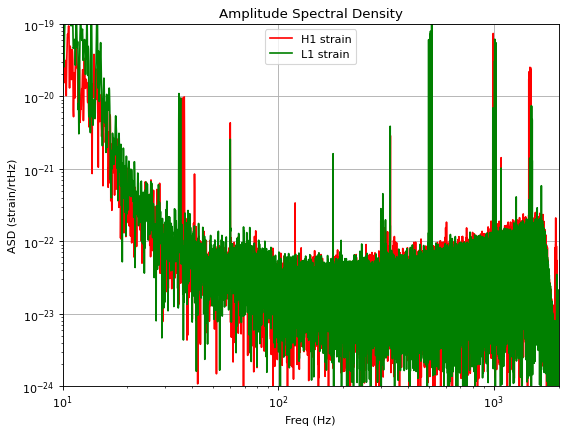

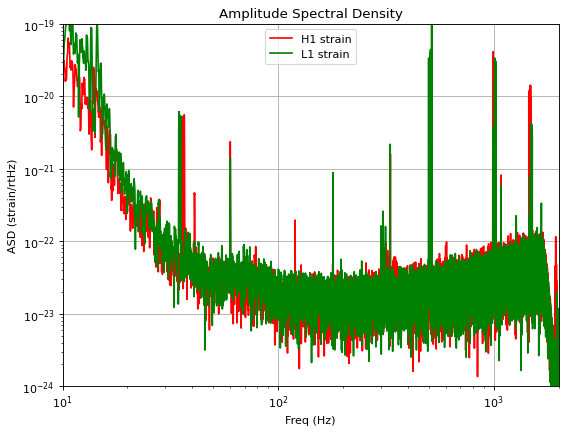

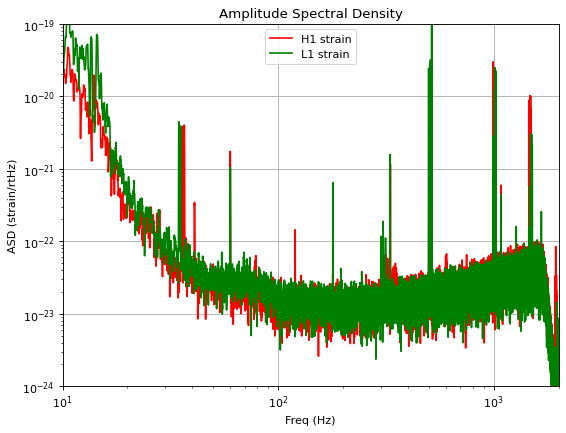

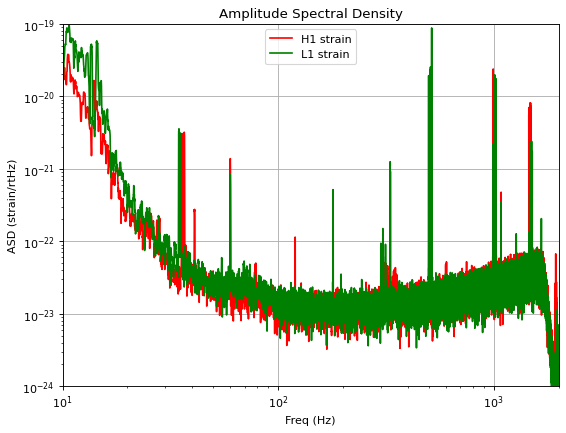

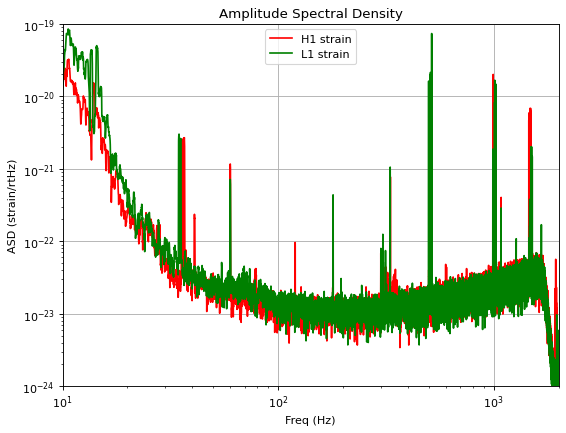

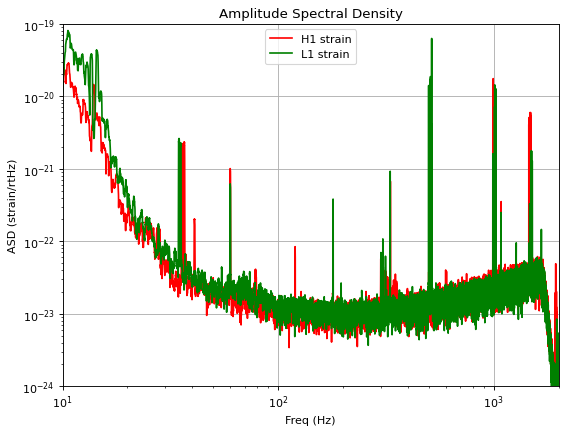

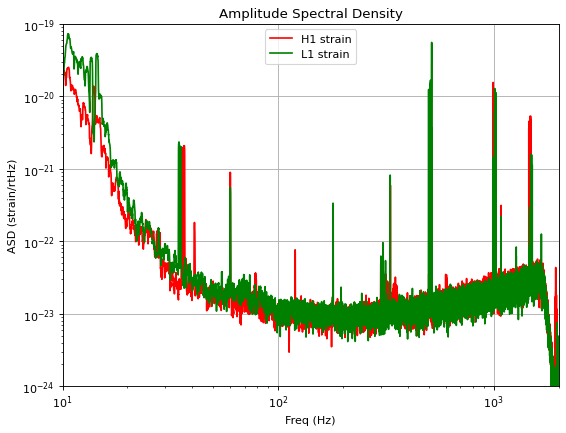

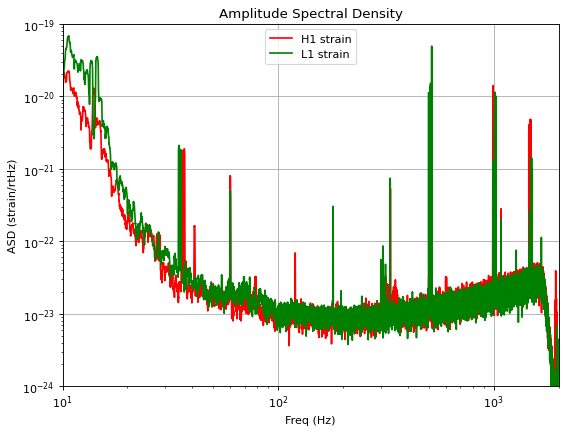

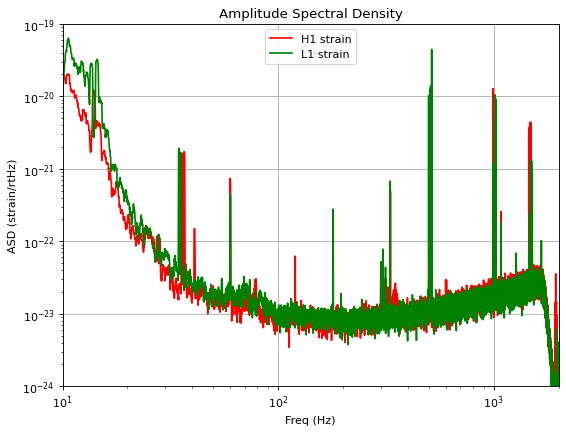

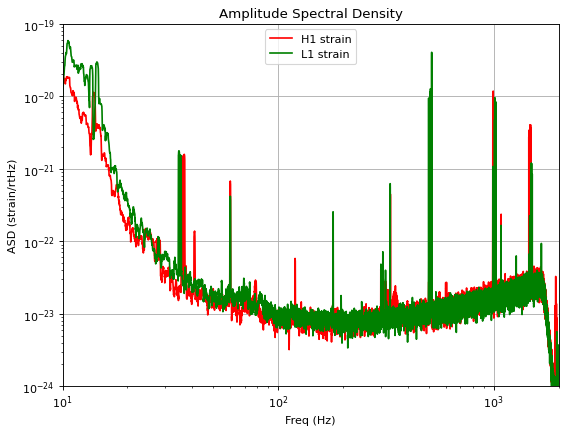

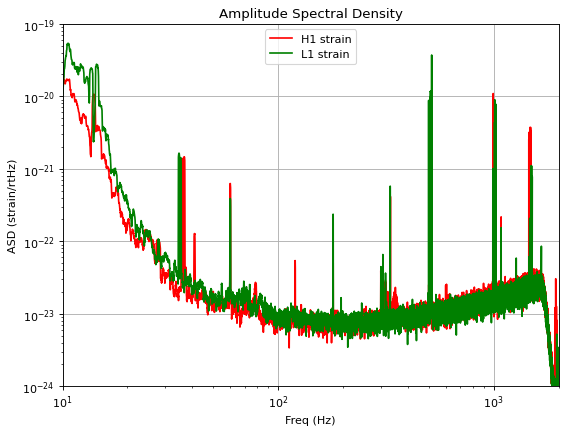

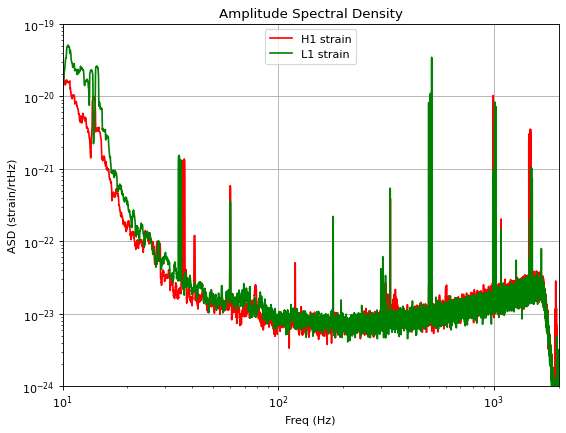

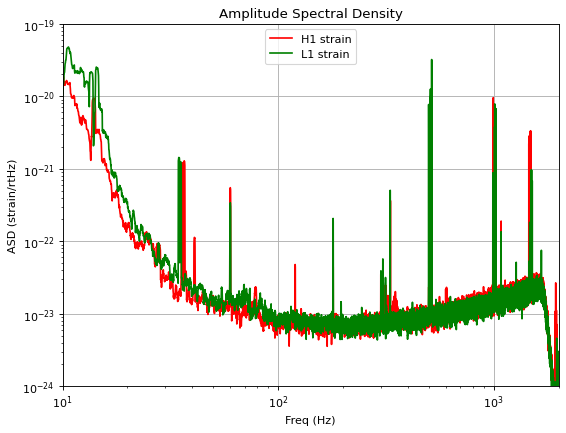

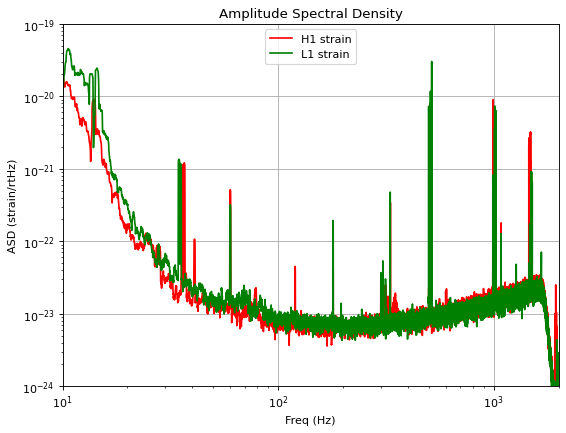

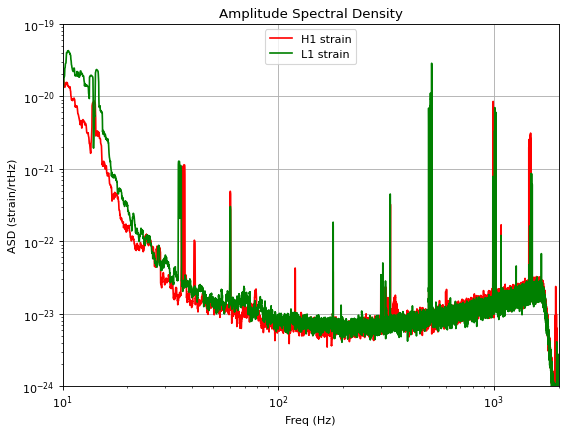

In [288]:
fmin = 10
fmax = 2000
for j in range(15):
    PxxH1_MT =  multitaperDPSS(dataH1,n=1+j,fs=4096)
    PxxL1_MT =  multitaperDPSS(dataL1,n=1+j,fs=4096)
    freqs1 = np.fft.fftfreq(len(dataH1),d=1/4096)
    freqs2 = np.fft.fftfreq(len(dataL1),d=1/4096)
    freqs1 = freqs1[:len(freqs1)//2]
    freqs2 = freqs2[:len(freqs2)//2]
    plotStrainASD(freqs1, freqs2, PxxH1_MT[:-1], PxxL1_MT[:-1], fmin, fmax, filename='ASD-Multitaper-Method-'+str(1+j)+'-taps.png')

# Metodo de Blackman-Tukey

Para estimar el espectro del ruido se decidio tomar muestras de la senal de forma tal que no se inlcluya el periodo de tiempo en el que aparece la señal correspondiente a la onda gravitacional.
El evento empieza en el segundo 16,422 del archivo utilizado.Dado que la frecuencia de muestreo del archivo es de 4096Hz, el tiempo del evento corresponderia a la muestra numero:
 $$N_{ev} = 16.422seg . 4096Hz= 67264  $$

Por lo que para no incluir al evento se eligen tomar muestras por debajo de 67264, para tener un margen de seguridad se eligio utilizar la potencia de 2 mas cercana por debajo de dicho limite:
$$N=65536$$
N es el valor de muestras utilizadas de la senal para estimar la autocorrelacion de la señal.
Mientras que para el valor de la cantidad de valores que se desea calcular de la autocorrrelacion (denominado L). Se decidio tomar:
$$L= N$$
Este valor se eligio ya que el tiempo de calculo no es ningun limitante en este caso y se desea la mayor resolucion epectral posible. 

In [289]:
def BlackmanTukey(data,N,L,M,nperseg=None):
  if nperseg==None:
    nperseg = 2*L-1
  #Estimate autocorrelation
  rx = np.correlate(data[0:N],data[0:N],mode='full') / N
  rx_truncated = rx[(N-L):(N+L-1)]
  #Apply window
  x = ( (2*M+1)/L )*np.linspace(start=-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
  window = ( (2*M+1)/L )*np.sinc(x)
  windowed_rx = rx_truncated*window
  #Calculate spectrum
  return abs( np.fft.rfft(windowed_rx,n=nperseg) )

In [290]:
N = 65536
L = N
M = 32

Estimo la correlacion de la señal

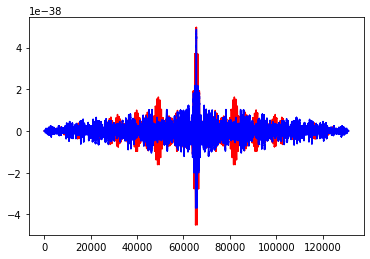

In [291]:
#Calculo rx para H1
meanless_h1 = dataH1[0:N] - np.mean(dataH1[0:N])
rx_h1 = np.correlate(meanless_h1,meanless_h1,mode='full') / N
rx_truncated_h1 = rx_h1[(N-L):(N+L-1)]
#Calculo rx para L1
meanless_l1 = dataL1[0:N] - np.mean(dataL1[0:N])
rx_l1 = np.correlate(meanless_l1,meanless_l1,mode='full') / N
rx_truncated_l1 = rx_l1[(N-L):(N+L-1)]

plt.plot(rx_truncated_h1,'r')
plt.plot(rx_truncated_l1,'b')
plt.show()

Aplico la ventana

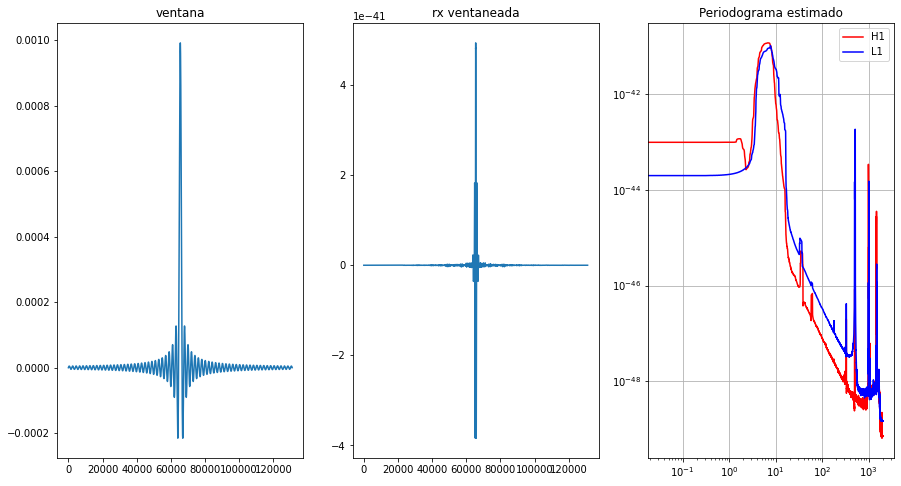

In [292]:
x = ( (2*M+1)/L )*np.linspace(start=-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
window = ( (2*M+1)/L )*np.sinc(x)

windowed_rx_h1 = rx_truncated_h1*window
spectrum_h1 = norm*abs( np.fft.rfft(windowed_rx_h1) )

windowed_rx_l1 = rx_truncated_l1*window
spectrum_l1 = norm*abs( np.fft.rfft(windowed_rx_l1) )

f = np.fft.fftfreq(n=len(windowed_rx_h1),d=1./4096)
fig = plt.figure(figsize=(15,8))
plt.subplot(131)
plt.plot(window)
plt.title("ventana")
plt.subplot(132)
plt.plot(windowed_rx_h1)
plt.title("rx ventaneada")
plt.subplot(133)
plt.title("Periodograma estimado")
plt.plot(f[0:L],spectrum_h1,'r',label='H1')
plt.plot(f[0:L],spectrum_l1,'b',label='L1')
plt.legend(loc="upper right")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

In [293]:
def AddSpectrumPlot(f_vect,spectrum,title,index,row=2,column=3):
  plt.subplot(row,column,index)
  plt.title(title)
  plt.plot(f_vect,spectrum)
  plt.yscale("log")
  plt.grid(True)

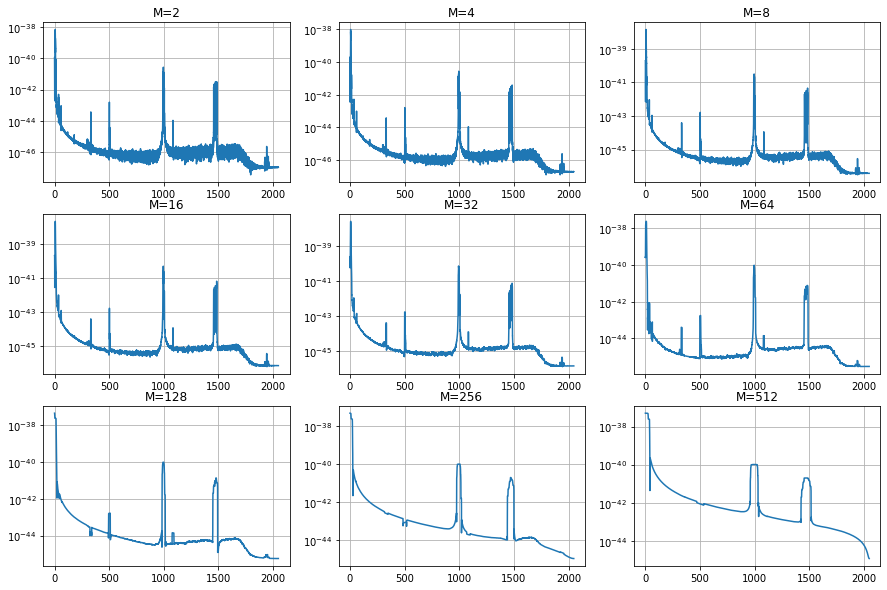

In [294]:
M_values = [2,4,8,16,32,64,128,256,512]
fig = plt.figure(figsize=(15,10))

for i in range(0,len(M_values)):
  M_test = M_values[i]
  x = ( (2*M_test+1)/L )*np.linspace(start=-L,stop=L,endpoint=False,num=2*L-1,dtype=int)
  window = ( (2*M_test+1)/L )*np.sinc(x)
  windowed_rx = rx_truncated_h1*window
  Rx_ps = np.fft.fft(windowed_rx)
  f = np.fft.fftfreq(n=len(windowed_rx),d=1./4096)
  AddSpectrumPlot(f[0:L],abs(Rx_ps)[0:L],title="M="+str(M_test),index=i+1,row=3,column=3)


plt.show()

Como ultima variable a definir, se decidio utilizar para el filtro moving average:
$$M=32$$
Se puede apreciar en las graficas anteriores que dicho valor parece estar justo en el limite entre un mejor suavizado y una perdida de detalle debido a falta de resolucion en frecuencia. La resolucion en frecuencia del espectro es obtiene como:
$$\triangle f=\frac{2M+1}{N}f_s=\frac{2*32+1}{65536}4096Hz\approx4Hz$$
Con este valor de M se obtiene una resolucion de 4Hz, ya con el proximo vaalor de M=64 la resolucion empeora a 8Hz.

# Comparacion entre estimaciones

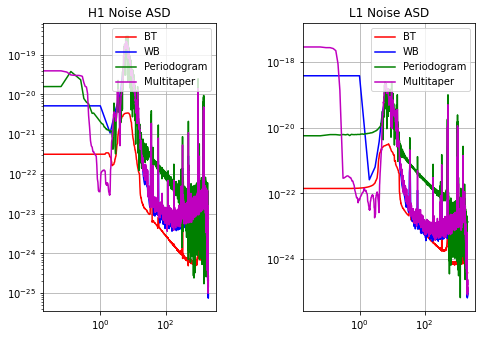

In [295]:
fig = plt.Figure(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.5)
#H1
f1 = np.fft.rfftfreq(2*len(spectrum_h1)-1,d=1./4096.) #BT freqs
f2 = np.fft.rfftfreq(2*len(PxxH1_WB)-1,d=1./4096.)    #WB freqs
f3 = np.fft.rfftfreq(2*len(fftH1)-1,d=1./4096.)    #WB freqs
f4 = np.fft.fftfreq(len(dataH1),d=1/4096)
f4 = f4[:len(f4)//2]
plt.subplot(121)
plt.title("H1 Noise ASD")
plt.plot(f1,np.sqrt(spectrum_h1),'r',label='BT')
plt.plot(f2,np.sqrt(PxxH1_WB),'b',label='WB')
plt.plot(f3,np.sqrt(PxxH1_FFT),'g',label='Periodogram')

PxxH1_MT =  multitaperDPSS(dataH1,n=8,fs=4096)
plt.plot(f4,np.sqrt(PxxH1_MT[:-1]),'m',label='Multitaper')
plt.legend(loc="upper right")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

#L1
f1 = np.fft.rfftfreq(2*len(spectrum_l1)-1,d=1./4096.) #BT freqs
f2 = np.fft.rfftfreq(2*len(PxxL1_WB)-1,d=1./4096.)    #WB freqs
f3 = np.fft.rfftfreq(2*len(fftL1)-1,d=1./4096.)    #WB freqs
f4 = np.fft.fftfreq(len(dataL1),d=1/4096)
f4 = f4[:len(f4)//2]
plt.subplot(122)
plt.title("L1 Noise ASD")
plt.plot(f1,np.sqrt(spectrum_l1),'r',label='BT')
plt.plot(f2,np.sqrt(PxxL1_WB),'b',label='WB')
plt.plot(f3,np.sqrt(PxxL1_FFT),'g',label='Periodogram')

PxxL1_MT =  multitaperDPSS(dataL1,n=8,fs=4096)
plt.plot(f4,np.sqrt(PxxL1_MT[:-1]),'m',label='Multitaper')
plt.legend(loc="upper right")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.show()


# Estimacion de la funcion de distribucion de probabilidad

## H1

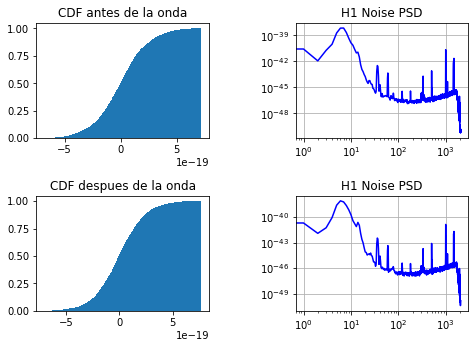

In [296]:
T_start = 65536
T_end = 67264+1024


fig = plt.Figure(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.5)

plt.subplot(221)
plt.title("CDF antes de la onda")
plt.hist(dataH1[0:T_start], bins=500,cumulative=True,density=True)

plt.subplot(222)
plt.title("H1 Noise PSD")
f = np.fft.rfftfreq(2*len(PxxH1_WB)-1,d=1./4096.)    #WB freqs
plt.plot(f,PxxH1_WB,'b')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(223)
plt.title("CDF despues de la onda")
plt.hist(dataH1[T_end:], bins=500,cumulative=True,density=True)

plt.subplot(224)
plt.title("H1 Noise PSD")
PxxH1_WB_end = welchBartlett(dataH1[T_end:], fs=4096, D=0, L=nperseg, k=len(dataH1[T_end:])//nperseg, window = signal.get_window('hann', nperseg))
f = np.fft.rfftfreq(2*len(PxxH1_WB_end)-1,d=1./4096.)    #WB freqs
plt.plot(f,PxxH1_WB_end,'b')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

A simple viste pareceria que no hay ninguna diferencia notable entre la funcion distribucion de probabilidad del ruido antes de la onda y despues.
Lo mismo se puede decir del espectro de potencia del ruido, por lo que se concluye que el ruido se puede tratar como estacionario en los 32 segundos de la señal.

## L1

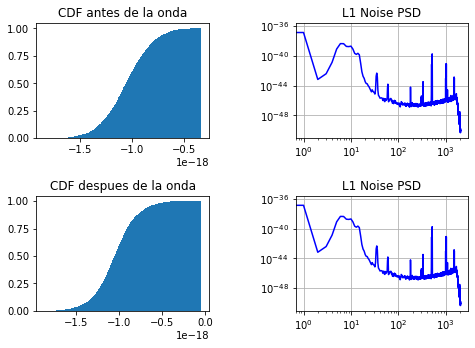

In [297]:
T_start = 65536
T_end = 67264+1024


fig = plt.Figure(figsize=(10,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.5, wspace = 0.5)

plt.subplot(221)
plt.title("CDF antes de la onda")
plt.hist(dataL1[0:T_start], bins=500,cumulative=True,density=True)

plt.subplot(222)
plt.title("L1 Noise PSD")
f = np.fft.rfftfreq(2*len(PxxL1_WB)-1,d=1./4096.)    #WB freqs
plt.plot(f,PxxL1_WB,'b')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

plt.subplot(223)
plt.title("CDF despues de la onda")
plt.hist(dataL1[T_end:], bins=500,cumulative=True,density=True)

plt.subplot(224)
plt.title("L1 Noise PSD")
PxxL1_WB_end = welchBartlett(dataL1[T_end:], fs=4096, D=0, L=nperseg, k=len(dataL1[T_end:])//nperseg, window = signal.get_window('hann', nperseg))
f = np.fft.rfftfreq(2*len(PxxL1_WB_end)-1,d=1./4096.)    #WB freqs
plt.plot(f,PxxL1_WB,'b')
plt.yscale("log")
plt.xscale("log")
plt.grid(True)
plt.show()

Comparando las graficas de la primera y la segunda mitad del set de datos podemos apreciar que no se perciben diferencias notables entre ambas.
Por lo que al igual que para H1, se cumple que el ruido se comporta como estacionario en los 32 segundos del dataset.

# Whitening

In [330]:

def whitening(data,psd,fs, filter=False):
    freqs = np.fft.rfftfreq(len(data),d=1/fs)
    dft = np.fft.rfft(data)
    whiteDft = dft / np.sqrt(psd)
    white_ht = np.fft.irfft(whiteDft)
    if (filter):
      bb, ab = signal.butter(4, [20.*2./fs, 300.*2./fs], btype='band')
      strain_H1_whitenbp = signal.filtfilt(bb, ab, white_ht)
      return strain_H1_whitenbp
      #start_index = (30*len(data))//fs
      #stop_index = (300*len(data))//fs
      #whiteDft[0:start_index] = 0
      #whiteDft[stop_index:] = 0
    return white_ht
def AddSpectrogramPlot(nfft,nperseg,data,title,index,row=2,column=2,fs=4096):
 plt.subplot(row,column,index)
 plt.title(title)
 f,t,Pxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, nfft=nfft, scaling='density', mode='psd')
 plt.pcolormesh(t, f, 10*np.log10(1+Pxx), cmap="viridis", shading='auto') #"gist_heat"
 plt.ylim(top=2000)

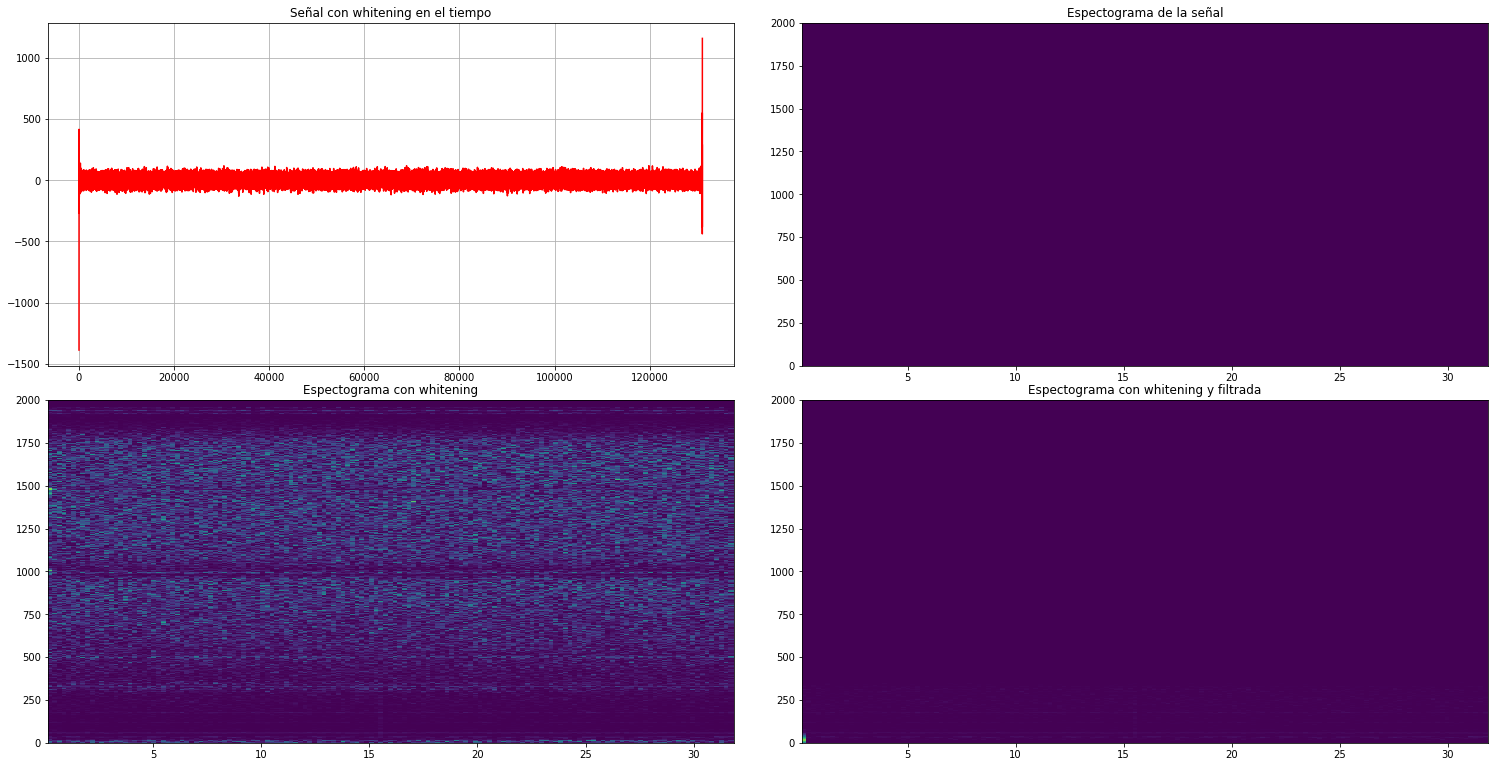

In [341]:
nperseg = 2**12
#psd_noise_h1 = welchBartlett(dataH1[0:65536], fs=4096, D=0, L=nperseg, k=65536//nperseg, window = signal.get_window('hann', nperseg), padding=len(dataH1)-nperseg)
#psd_noise_l1 = welchBartlett(dataL1[0:65536], fs=4096, D=0, L=nperseg, k=65536//nperseg, window = signal.get_window('hann', nperseg), padding=len(dataH1)-nperseg)
psd_noise_h1 = BlackmanTukey(dataH1,65537,65537,16)
whitened_signal_h1 = whitening(dataH1,psd_noise_h1,4096)
#whitened_signal_l1 = whitening(dataL1,psd_noise_l1,4096)
#print(whitened_signal_h1)

plt.figure(figsize=(20,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.1, wspace = 0.1)
plt.subplot(221)
plt.title("Señal con whitening en el tiempo")
plt.plot(whitened_signal_h1,'r',label='H1')
plt.grid(True)
#original
AddSpectrogramPlot(nfft=8192,nperseg=1024,data=dataH1,title="Espectograma de la señal",index=2)
#Whitening
AddSpectrogramPlot(nfft=8192,nperseg=1024,data=whitened_signal_h1,title="Espectograma con whitening",index=3)
#Whitening y filtrada
filtered_signal_h1 = whitening(dataH1,psd_noise_h1,4096,filter=True)
AddSpectrogramPlot(nfft=8192,nperseg=1024,data=filtered_signal_h1,title="Espectograma con whitening y filtrada",index=4)
plt.savefig('whitening.png')
plt.show()

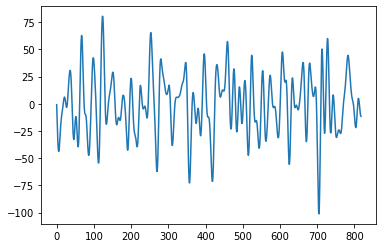

In [332]:
plt.plot(filtered_signal_h1[Nevent:Nend])

Utilizando le intervalo de tiempo donde se encuentra la señal tenemos:

819


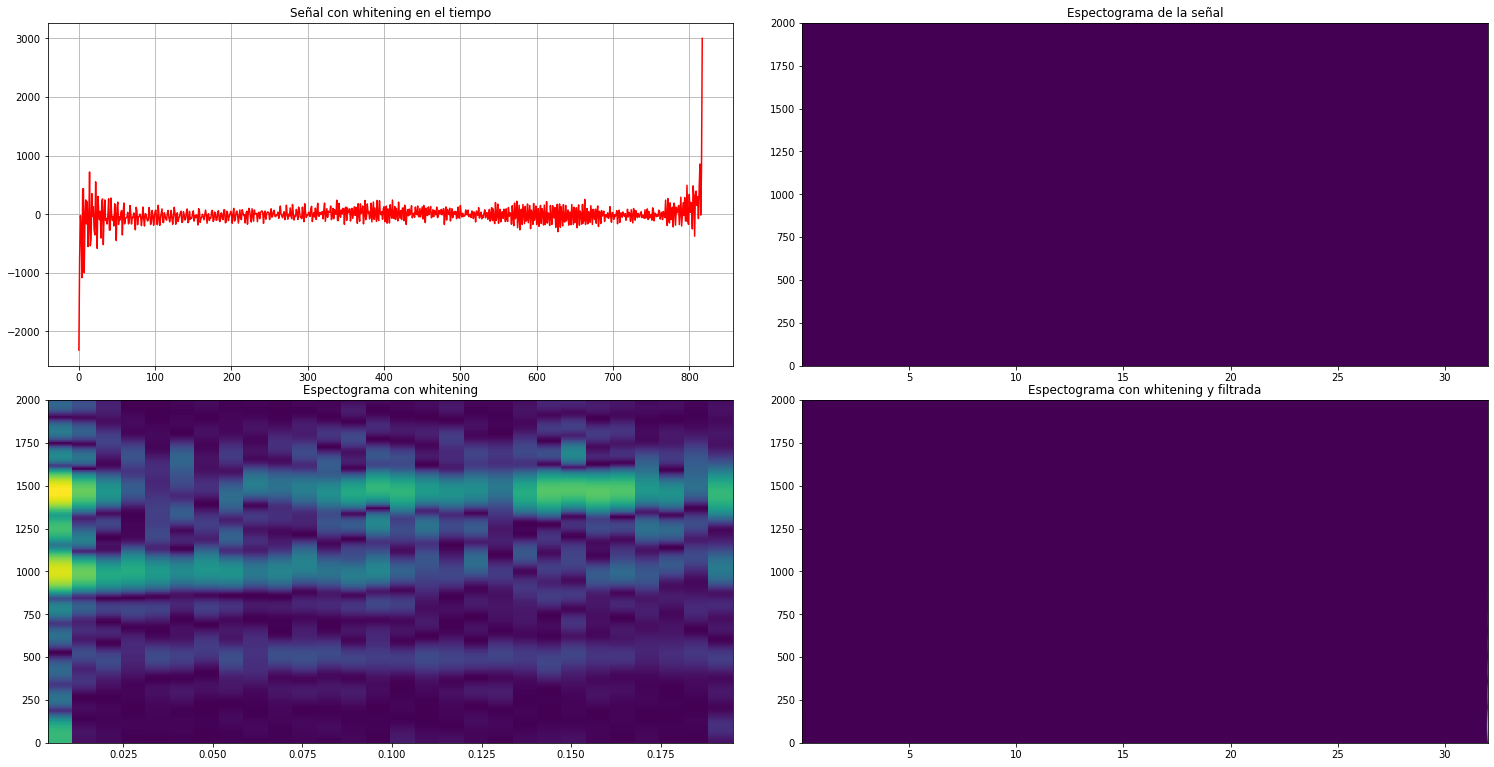

In [333]:
nperseg = 2**12
Nevent = 67264
Nend = Nevent + int(200e-3*4096)
print(len(dataH1[Nevent:Nend]))
psd_noise_h1 = welchBartlett(dataH1[0:65536], fs=4096, D=0, L=nperseg, k=65536//nperseg, window = signal.get_window('hann', nperseg), padding=len(dataH1[Nevent:Nend])-nperseg)
psd_noise_l1 = welchBartlett(dataL1[0:65536], fs=4096, D=0, L=nperseg, k=65536//nperseg, window = signal.get_window('hann', nperseg), padding=len(dataH1[Nevent:Nend])-nperseg)
#psd_signal_h1 = welchBartlett(dataH1[Nevent:Nend], fs=4096, D=0, L=nperseg, k=int(200e-3*4096)//nperseg,
#                             window = signal.get_window('hann', nperseg), padding=len(dataH1)-nperseg)
#psd_signal_l1 = welchBartlett(dataL1[Nevent:Nend], fs=4096, D=0, L=nperseg, k=int(200e-3*4096)//nperseg,
#                             window = signal.get_window('hann', nperseg), padding=len(dataL1)-nperseg)
whitened_signal_h1 = whitening(dataH1[Nevent:Nend],psd_noise_h1,4096)
whitened_signal_l1 = whitening(dataL1[Nevent:Nend],psd_noise_l1,4096)

plt.figure(figsize=(20,10))
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0.1, wspace = 0.1)
plt.subplot(221)
plt.title("Señal con whitening en el tiempo")
plt.plot(whitened_signal_h1,'r',label='H1')
plt.grid(True)
#original
AddSpectrogramPlot(nfft=1024,nperseg=32,data=dataH1,title="Espectograma de la señal",index=2)
#Whitening
AddSpectrogramPlot(nfft=1024,nperseg=32,data=whitened_signal_h1,title="Espectograma con whitening",index=3)
#Whitening y filtrada
filtered_signal_h1 = whitening(dataH1,psd_signal_h1,4096,filter=True)
AddSpectrogramPlot(nfft=1024,nperseg=32,data=filtered_signal_h1,title="Espectograma con whitening y filtrada",index=4)
plt.show()

# TERMINAR
WHITENING + PASA BANDA
ESCUCHAR RUIDO 
ESTIMAR CORRELACION CRUZADA
INFORME